# FSL Nets Analyisis: Exploratory Framework

### Author: Marc Biosca

In [2]:
from glob import glob
from fsl import nets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from fsl.nets.load import TimeSeries
from scipy import stats
import seaborn as sns

In [3]:
folder = '/home/biofisica/Escritorio/melodic_output_rand_3/'
design_matrix_path = folder + 'ica_glm_design_centiloid_897.mat'
contrast_matrix_path = folder + 'ica_glm_design_centiloid_897.con'

In [4]:
# load the timeseries data from a dual regression output directory
ts = nets.load(folder + 'dr_897subjects/', 3, thumbnaildir=folder + 'groupICA30.sum/')
ts_reg = nets.load(folder + 'dr_897subjects/', 3, thumbnaildir=folder + 'groupICA30.sum/')

<Figure size 640x480 with 0 Axes>

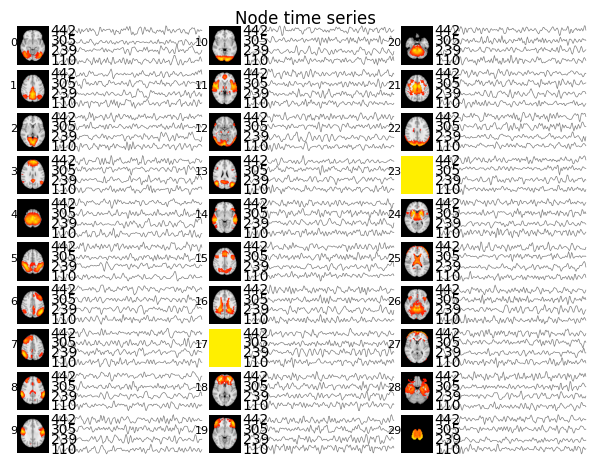

<Figure size 640x480 with 0 Axes>

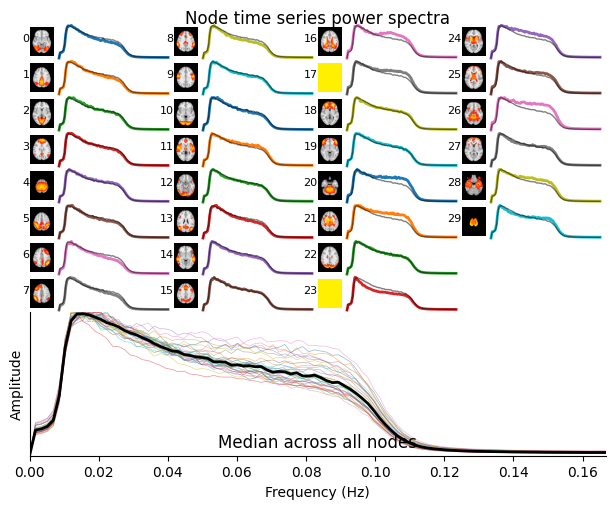

In [5]:
# View the timeseries data and power spectra
plt.figure()
nets.plot_timeseries(ts)
fig = plt.gcf()
plt.show()

plt.figure()
nets.plot_spectra(ts)
fig = plt.gcf()
plt.show()

In [6]:
# Indicate goodnodes
goodnodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,14,15, 18, 19]

network_order = [13,1,14,3,7,6,19,18,11,9,4,5,8,15,2,0,10]

correspondence = {0:'Visual 2',
                  1: 'DMN',
                  2: 'Visual 1',
                  3: 'DMN Frontal',
                  4: 'Sensory Motor',
                  5: 'Executive 2',
                  6: 'Left Fronto Parietal',
                  7: 'Right Fronto Parietal',
                  8: 'Fronto Parietal',
                  9: 'Sensory Temporal',
                  10: 'Visual 3',
                  11: 'Salience',
                  13: 'DMN Posterior 1',
                  14: 'DMN Posterior 2',
                  15: 'Executive 3',
                  18: 'Frontal',
                  19: 'Executive 1'}

print('Number of good nodes: ', len(goodnodes))

# Regress out the time course of bad nodes
nets.clean(ts, goodnodes, False)
nets.clean(ts_reg, goodnodes, True)


Number of good nodes:  17


In [7]:
# Calculate connectivity estimates
Anetmats =nets.netmats(ts, 'amp', True)
Fnetmats = nets.netmats(ts, 'corr', True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1)

Anetmats_reg =nets.netmats(ts_reg, 'amp', True)
Fnetmats_reg = nets.netmats(ts_reg, 'corr', True)
Pnetmats_reg = nets.netmats(ts_reg, 'ridgep', True, 0.1)

print('Full correlation matrix shape:', Fnetmats.shape)
print('Partial correlation matrix shape:', Pnetmats.shape)


print(Anetmats.shape)
print('Number of nodes:', len(goodnodes))
print('Number of connections:', len(goodnodes)*len(goodnodes))

# Calculate group mean connectivity
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, False)

Full correlation matrix shape: (897, 289)
Partial correlation matrix shape: (897, 289)
(897, 17)
Number of nodes: 17
Number of connections: 289


invalid value encountered in divide


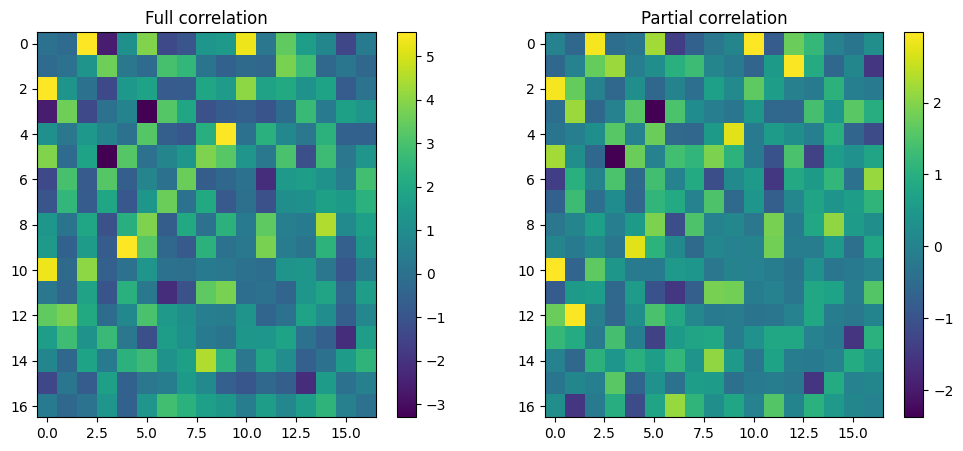

In [8]:
# Heatmap of mean connectivity - Full and Partial

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(Mnet_F, aspect='auto')
plt.colorbar()
plt.title('Full correlation')
plt.subplot(1,2,2)
plt.imshow(Mnet_P, aspect='auto')
plt.colorbar()
plt.title('Partial correlation')
fig = plt.gcf()
plt.show()

<Figure size 640x480 with 0 Axes>

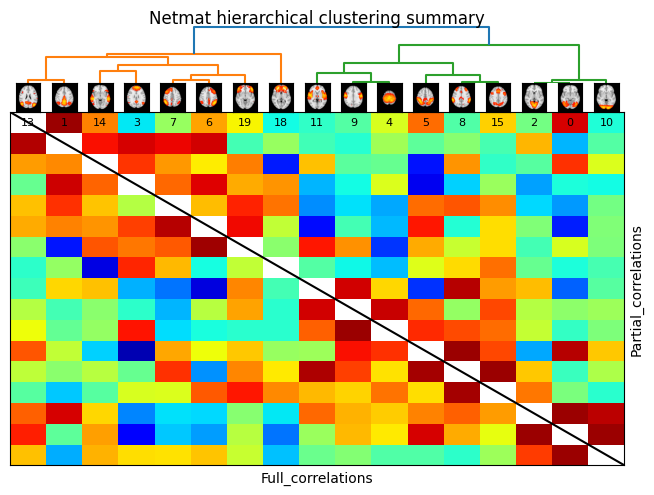

In [9]:
#Inspect hierarchical clustering on the full correlation matrix

plt.figure()
nets.plot_hierarchy(ts, Znet_F, Znet_P, 'Full_correlations', 'Partial_correlations')
fig = plt.gcf()
plt.show()

network_order = [13,1,14,3,7,6,19,18,11,9,4,5,8,15,2,0,10]


### CSV File Saving

In [10]:

path_to_data = '/home/biofisica/Escritorio/melodic_output_rand_3/random_898.csv'

data = pd.read_csv(path_to_data)

path_to_txt = '/home/biofisica/Escritorio/melodic_output_rand_3/my_list_yes_897.txt'

# strcuture: /pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc/sub-B82098340/ses-01/sub-B82098340_ses-01_task-rest_bold_desc-ts-mc-cleaned-final-reg-template.nii.gz

# Extract a list of BIDS ids from the txt file
with open(path_to_txt, 'r') as f:
    lines = f.readlines()
    
BIDS_ids = [line.split('/')[-3][4:] for line in lines]

# Create an empty dataframe
df = pd.DataFrame()

columns = ['BID', 'centiloid', 'PTAGE', 'PTGENDER']
count = 0
for subject in BIDS_ids:
    subject_data = data[data['BID'] == subject]
    subject_data['idx'] = count
    subject_data = subject_data[['BID', 'idx', 'centiloid', 'PTAGE', 'PTGENDER', 'Screening PACC Score', 'APOEGN', 'PTEDUCAT']]
    df = pd.concat([df, subject_data])
    count += 1
    
#df['centiloid'] = df['centiloid'] - np.mean(df['centiloid'])

#df['PTAGE'] = df['PTAGE'] - np.mean(df['PTAGE'])

df['PTGENDER'] = df['PTGENDER'].replace({'Male': 0, 'Female': 1})
df['E4_carrier'] = df['APOEGN'].apply(lambda x: 1 if x == 'E3/E4' or x == 'E4/E4' or x == 'E2/E4' else 0)

# Drop column APOEGN
df = df.drop('APOEGN', axis=1)

# Z-normalize the data SPACC
#df['Screening PACC Score'] = df['Screening PACC Score'] - np.mean(df['Screening PACC Score'])

data = df.copy()

tau_path = '/mnt/B468D0C568D0878E/usuarios/MarcBiosca/A4/A4_raw_data/CSV_Data_A4'
tau_df = pd.read_csv(tau_path + '/TAUSUVR_16Dec2024.csv')
tau_df['TAU'] = 1

# merge data and tau_df on data['BID'] == tau_df['ID']
# If the BID is not in tau_df, put a NaN value
data = data.merge(tau_df, left_on='BID', right_on='ID', how='left')

# Drop the ID column
data = data.drop(['ID', 'update_stamp'], axis=1)
data = data.drop(['bi_vessel', 'Volume_mm3_non_WM_hypointensities', 'Mean_non_WM_hypointensities', 'Mean_Left_vessel', 'bi_Cerebellum_Cortex', 'Mean_Right_vessel', 'Volume_mm3_Left_vessel', 'Volume_mm3_Right_vessel'], axis=1)


data['TAU'] = data['TAU'].fillna(0)

data.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,BID,idx,centiloid,PTAGE,PTGENDER,Screening PACC Score,PTEDUCAT,E4_carrier,Mean_3rd_Ventricle,Mean_4th_Ventricle,...,bi_rostralanteriorcingulate,bi_rostralmiddlefrontal,bi_superiorfrontal,bi_superiorparietal,bi_superiortemporal,bi_supramarginal,bi_temporalpole,bi_transversetemporal,bi_totalWM,TAU
0,B14030825,0,66.2231,79.06,0,-3.056524,19.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,B17148421,1,97.3450,69.32,0,0.645368,18.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,B34710358,2,64.3924,68.78,0,2.805492,19.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,B45245974,3,38.7626,68.04,0,1.419258,18.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,B48922607,4,106.4980,69.76,1,2.180290,24.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [11]:
for el in range(Anetmats.shape[1]):
    a = goodnodes[el]
    data['fslnets_amp_ic' + str(goodnodes[el])] = Anetmats[:, el].tolist()

for el in range(Anetmats_reg.shape[1]):
    data['fslnets_amp2_ic' + str(goodnodes[el])] = Anetmats_reg[:, el].tolist()

for el in range(Fnetmats.shape[1]):
    data['fslnets_Fcorr_' + str(el)] = Fnetmats[:, el].tolist()

for el in range(Pnetmats.shape[1]):
    data['fslnets_Pcorr_' + str(el)] = Pnetmats[:, el].tolist()

for el in range(Fnetmats_reg.shape[1]):
    data['fslnets_Fcorr_regres_' + str(el)] = Fnetmats_reg[:, el].tolist()

for el in range(Pnetmats_reg.shape[1]):
    data['fslnets_Pcorr_regres_' + str(el)] = Pnetmats_reg[:, el].tolist()


# Sum of all Pcorr and Fcorr features
data['fslnets_sum_Pcorr'] = [sum(x) for x in zip(*[data['fslnets_Pcorr_' + str(el)] for el in range(Pnetmats.shape[1])])]
data['fslnets_sum_Fcorr'] = [sum(x) for x in zip(*[data['fslnets_Fcorr_' + str(el)] for el in range(Fnetmats.shape[1])])]


data.head()

# Save the data
data.to_csv(folder + 'data_fslnets.csv', index=False)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

## Exploratory Framework: Integration of Tau SUVR variables and Structural MRI variables - Proof of Concept

Maximum correlation value: 0.26311708161407993
Maximum correlation value location: (np.int64(26), np.int64(138))
Tau column with maximum correlation: Mean_ctx_lh_rostralanteriorcingulate
FSLNets column with maximum correlation: fslnets_Pcorr_147


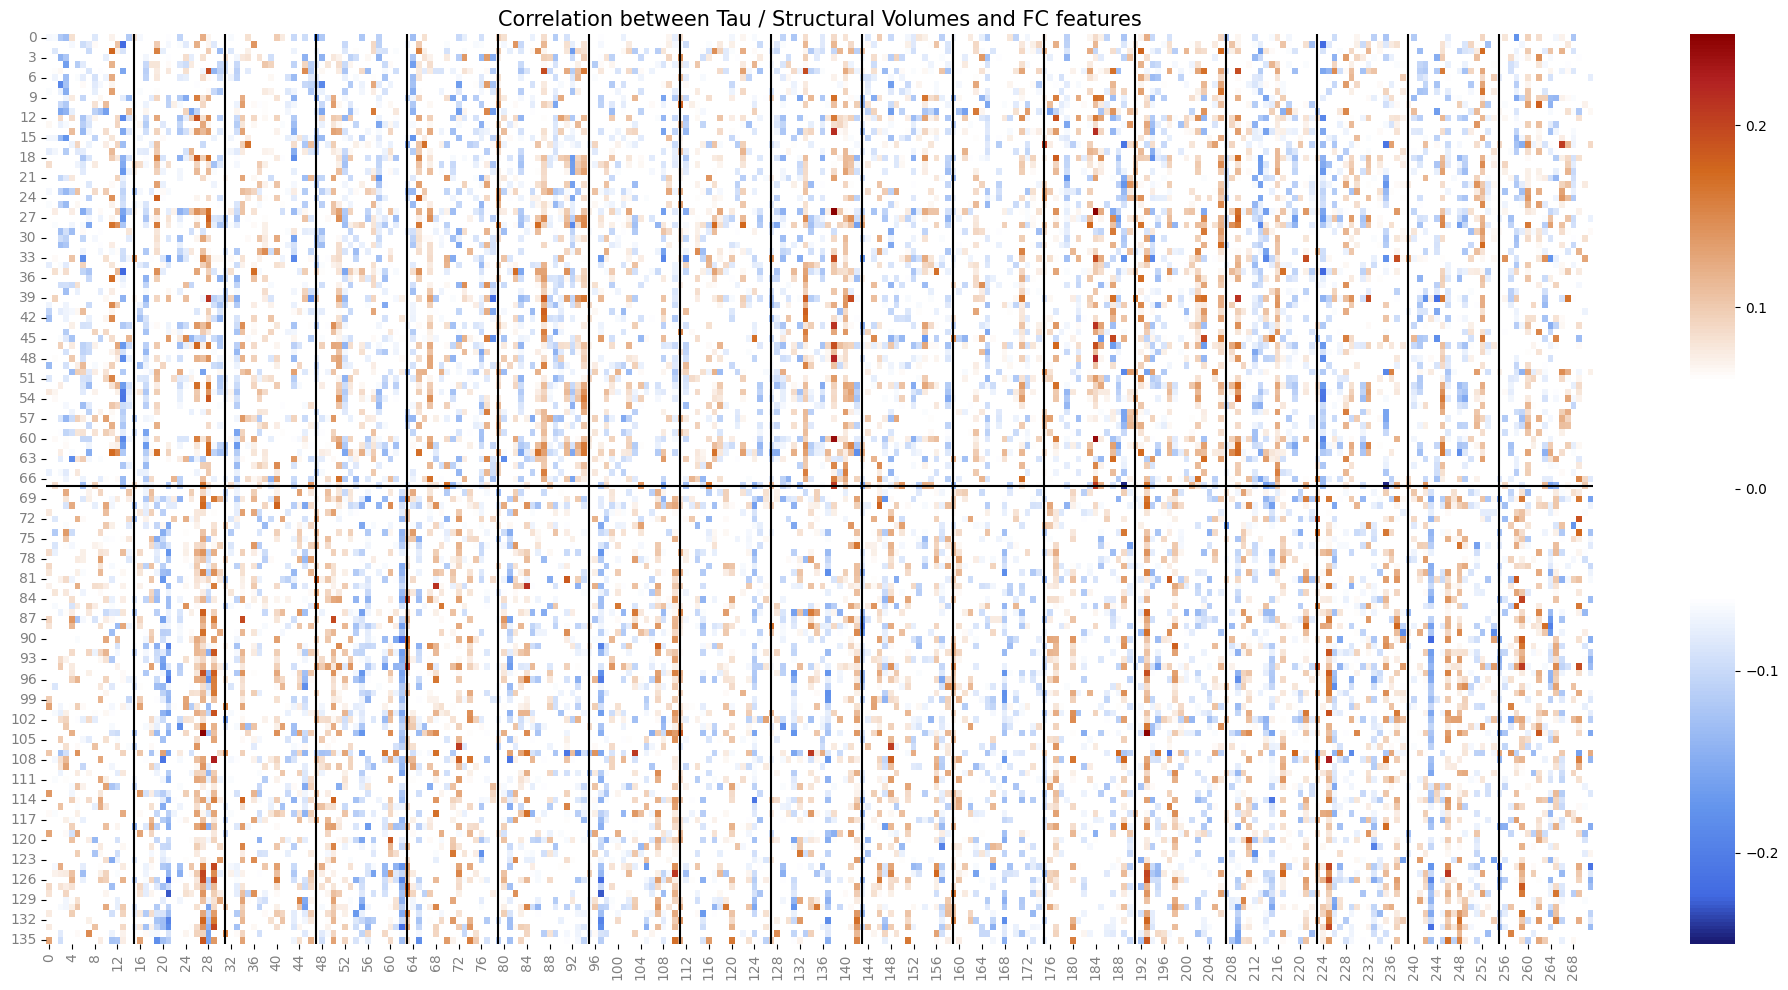

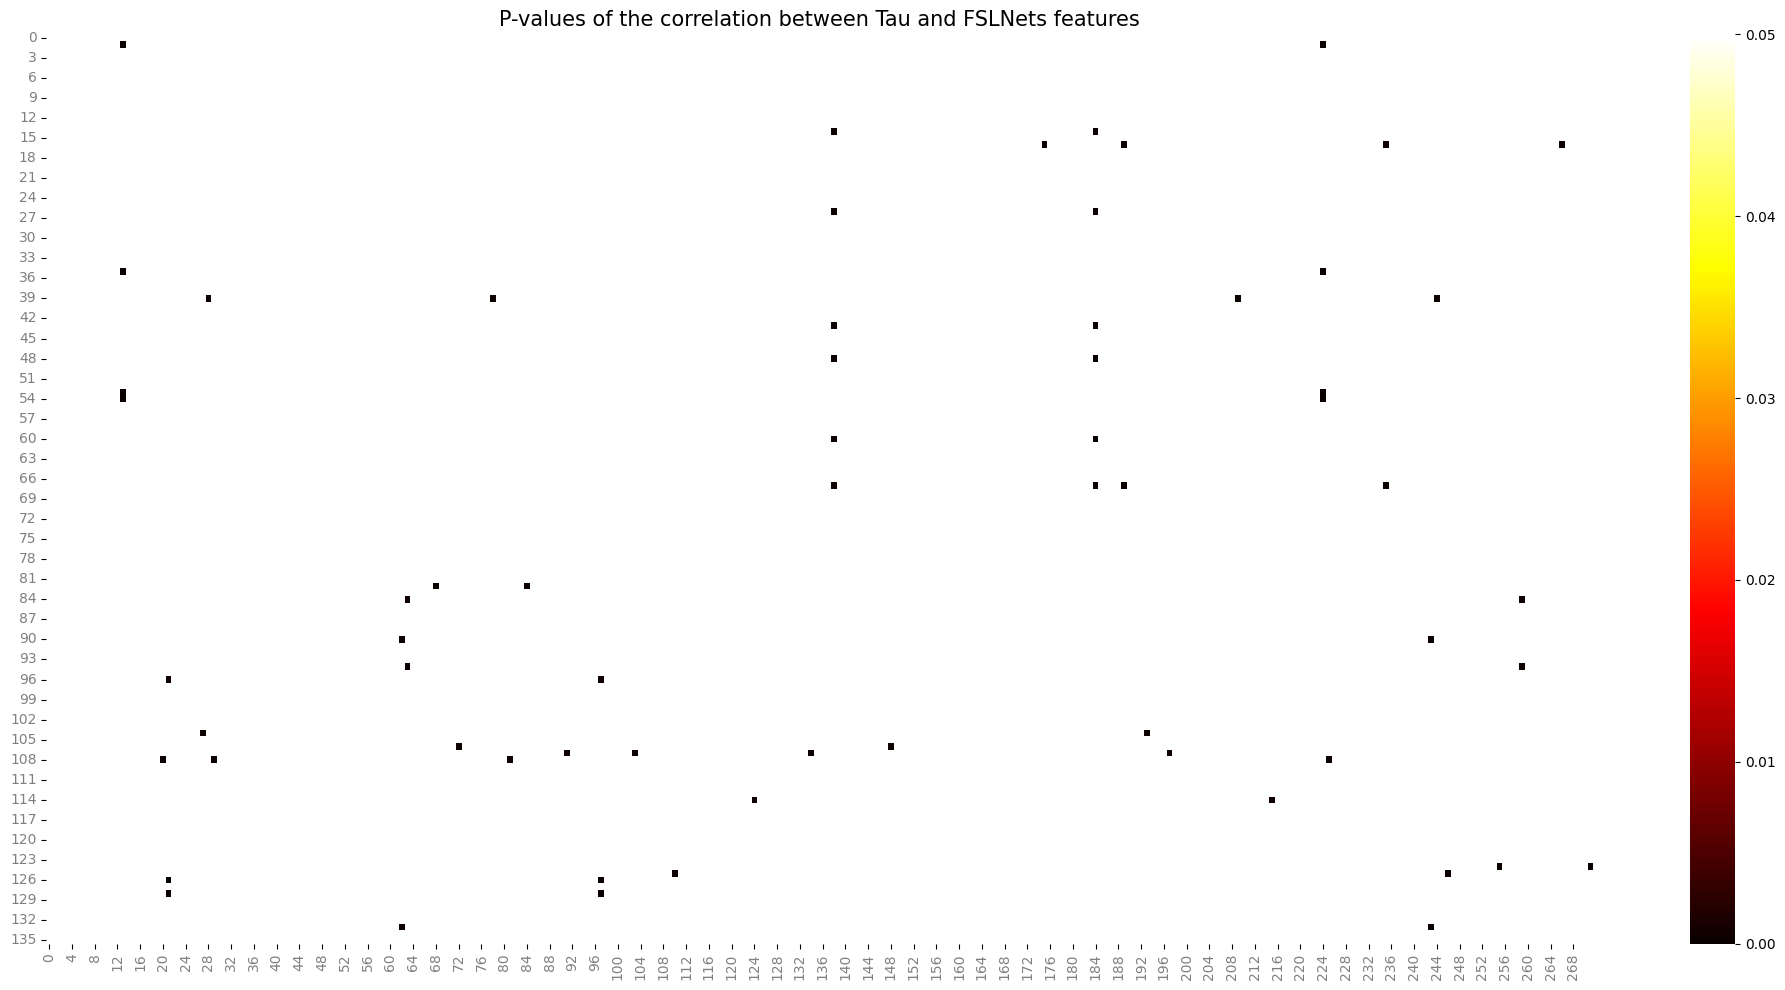

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
colors = [
    (0, "midnightblue"),
    (0.05, "royalblue"),
    (0.15, "cornflowerblue"),
    (0.38, "white"),
    (0.62, "white"),
    (0.85, "chocolate"),
    (0.95, "firebrick"),
    (1, "darkred")
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Filter data where 'TAU' == 1
data_tau = data[data['TAU'] == 1].copy()

# Select columns that start with 'Mean_ctx' or 'Volume_mm3_ctx'
columns_Tau = [col for col in tau_df.columns if col.startswith(('Mean_ctx', 'Volume_mm3_ctx'))]

# Count the number of columns starting with 'Mean_ctx'
number_mean_cols = sum(col.startswith('Mean_ctx') for col in columns_Tau)

# Generate flattened upper triangle indices for a 17x17 matrix
indices = np.triu_indices(17, k=1)
flattened_indices = indices[0] * 17 + indices[1]

# Generate diagonal indices
diag_indices_flattened = np.arange(17) * 17 + np.arange(17)

# Flag to determine which columns to include
repeat = True

# Select fslnets columns based on the 'repeat' flag
if repeat:
    excluded_indices = set(diag_indices_flattened)
    columns_fslnets = [f'fslnets_Pcorr_{i}' for i in range(17*17) if i not in excluded_indices]
else:
    columns_fslnets = [f'fslnets_Pcorr_{i}' for i in flattened_indices]

# Initialize correlation and p-values matrices
num_tau = len(columns_Tau)
num_fslnets = len(columns_fslnets)
correlation_matrix = np.empty((num_tau, num_fslnets))
p_values_matrix = np.empty((num_tau, num_fslnets))

# Compute correlation and p-values using nested loops
for i, tau_column in enumerate(columns_Tau):
    tau_values = data_tau[tau_column].values
    for j, fslnets_column in enumerate(columns_fslnets):
        fslnets_values = data_tau[fslnets_column].values
        # Check if either column has constant values
        if np.std(tau_values) == 0 or np.std(fslnets_values) == 0:
            r_value = np.nan
            p_value = np.nan
        else:
            r_value, p_value = stats.pearsonr(fslnets_values, tau_values)
        correlation_matrix[i, j] = r_value
        p_values_matrix[i, j] = p_value

# Find the maximum correlation value and its location
max_corr = np.nanmax(correlation_matrix)
max_corr_indices = np.unravel_index(np.nanargmax(correlation_matrix), correlation_matrix.shape)
tau_column_name = columns_Tau[max_corr_indices[0]]
fslnets_column_name = columns_fslnets[max_corr_indices[1]]

print('Maximum correlation value:', max_corr)
print('Maximum correlation value location:', max_corr_indices)
print('Tau column with maximum correlation:', tau_column_name)
print('FSLNets column with maximum correlation:', fslnets_column_name)

# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap=custom_cmap, annot=False, fmt=".2f", vmin=-0.25, vmax=0.25)

# Add vertical lines at every 'step' columns
step = 16
num_cols = num_fslnets
for i in range(step, num_cols, step):
    plt.axvline(i - 0.5, color='black', linewidth=1.5)

# Add a horizontal line after the mean columns
plt.axhline(number_mean_cols - 0.5, color='black', linewidth=1.5)

plt.title('Correlation between Tau / Structural Volumes and FC features', fontsize=15)
plt.xticks(fontsize=10, color='black', alpha=0.5, rotation=90)
plt.yticks(fontsize=10, color='black', alpha=0.5)
plt.tight_layout()
plt.show()

# Apply Bonferroni correction
alpha = 0.05 / (17*(17-1)/2)
p_values_matrix_significant = np.where(p_values_matrix <= alpha, p_values_matrix, np.nan)

# Plot the p-values heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(p_values_matrix_significant, cmap='hot', annot=False, fmt=".2f", vmin=0, vmax=0.05)
plt.title('P-values of the correlation between Tau and FSLNets features', fontsize=15)
plt.xticks(fontsize=10, color='black', alpha=0.5, rotation=90)
plt.yticks(fontsize=10, color='black', alpha=0.5)
plt.tight_layout()
plt.show()


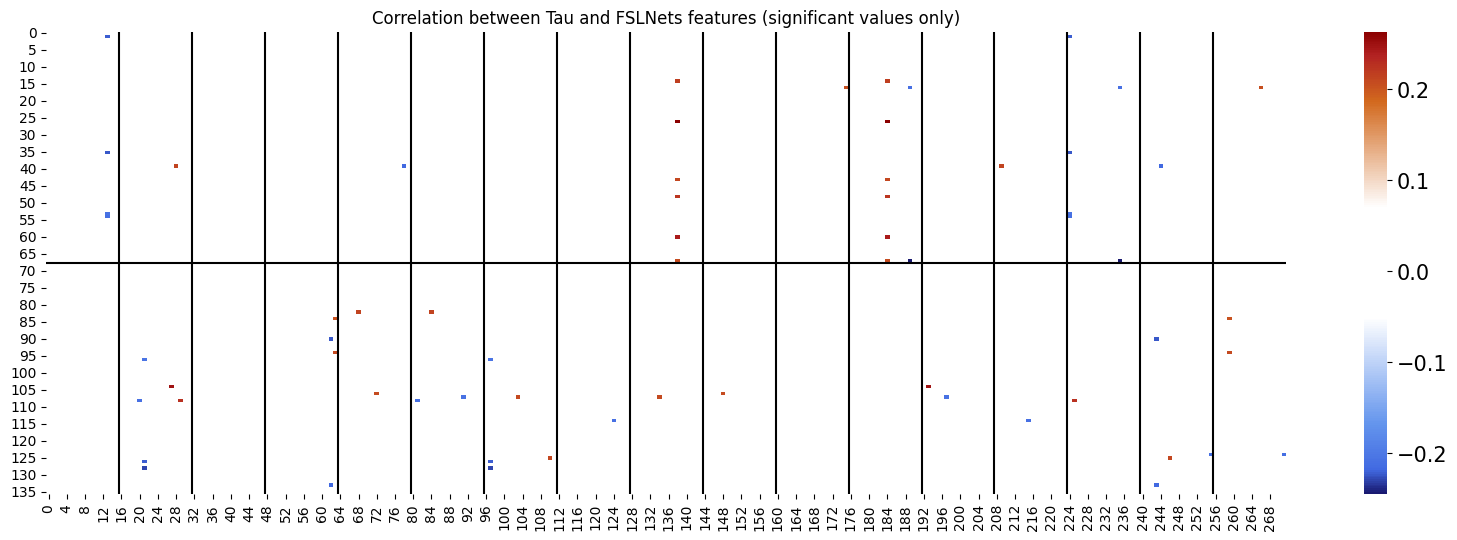

,Tau_column,FSLNets_column,Correlation,P-value
0,Mean_ctx_lh_rostralanteriorcingulate,fslnets_Pcorr_195,0.263117,0.000003
1,Mean_ctx_lh_rostralanteriorcingulate,fslnets_Pcorr_147,0.263117,0.000003
2,Volume_mm3_ctx_rh_caudalmiddlefrontal,fslnets_Pcorr_29,0.248839,0.000010
3,Volume_mm3_ctx_rh_caudalmiddlefrontal,fslnets_Pcorr_205,0.248839,0.000010
4,Mean_ctx_rh_transversetemporal,fslnets_Pcorr_249,-0.244374,0.000014


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mask the correlation matrix for significant values only
correlation_matrix_significant = correlation_matrix.copy()
correlation_matrix_significant[p_values_matrix > alpha] = np.nan

# Plot the heatmap with significant correlations
plt.figure(figsize=(20, 6))
hi = sns.heatmap(correlation_matrix_significant, cmap=custom_cmap, annot=False, fmt=".2f")
plt.title('Correlation between Tau and FSLNets features (significant values only)')

# Adjust colorbar tick size
hi.collections[0].colorbar.ax.tick_params(labelsize=15)

# Add vertical lines at specified steps
for i in range(step, num_cols, step):
    plt.axvline(i, color='black', linewidth=1.5)

# Add a horizontal line after mean columns
plt.axhline(number_mean_cols, color='black', linewidth=1.5)

plt.show()

# Create a mask for significant correlations
mask = p_values_matrix <= alpha

# Extract indices of significant correlations
tau_indices, fslnets_indices = np.where(mask)

# Build the results DataFrame efficiently
results_df = pd.DataFrame({
    'Tau_column': np.array(columns_Tau)[tau_indices],
    'FSLNets_column': np.array(columns_fslnets)[fslnets_indices],
    'Correlation': correlation_matrix[tau_indices, fslnets_indices],
    'P-value': p_values_matrix[tau_indices, fslnets_indices]
}).sort_values(by='P-value').reset_index(drop=True)

results_df.head()


In [14]:
# Count the number of significant correlations for every Tau feature
significant_correlations = np.nansum(p_values_matrix < alpha, axis=1)
correlation_sig_sum = np.nansum(np.abs(correlation_matrix_significant), axis=1)


# Create a DataFrame to store the results
results_tau_df = pd.DataFrame({
    'Tau Feature': columns_Tau,
    'Significant Correlations': significant_correlations,
    'Correlation Sum': correlation_sig_sum,
    'Mult': significant_correlations * correlation_sig_sum
})

# Sort the DataFrame by the number of significant correlations
results_tau_df = results_tau_df.sort_values('Mult', ascending=False)

# Display the results
results_tau_df.head()

,Tau Feature,Significant Correlations,Correlation Sum,Mult
67,Mean_ctx_rh_transversetemporal,4,0.903571,3.614285
108,Volume_mm3_ctx_rh_fusiform,4,0.874654,3.498616
39,Mean_ctx_rh_frontalpole,4,0.859690,3.438759
16,Mean_ctx_lh_paracentral,4,0.831901,3.327603
107,Volume_mm3_ctx_rh_frontalpole,4,0.831656,3.326623


In [15]:
# Count the number of significant correlations for every Tau feature
significant_correlations = np.sum(p_values_matrix < alpha, axis=0)
correlation_sig_sum = np.nansum(np.abs(correlation_matrix_significant), axis=0)


# Create a DataFrame to store the results
results_nets_df = pd.DataFrame({
    'FSL Nets Feature': columns_fslnets,
    'Significant Correlations': significant_correlations,
    'Correlation Sum': correlation_sig_sum,
    'Mult': significant_correlations * correlation_sig_sum
})

# Sort the DataFrame by the number of significant correlations
results_nets_df = results_nets_df.sort_values('Mult', ascending=False)

# Display the results
results_nets_df.head()

,FSL Nets Feature,Significant Correlations,Correlation Sum,Mult
184,fslnets_Pcorr_195,6,1.362666,8.175998
138,fslnets_Pcorr_147,6,1.362666,8.175998
224,fslnets_Pcorr_238,4,0.863717,3.454867
13,fslnets_Pcorr_14,4,0.863717,3.454867
21,fslnets_Pcorr_23,3,0.657267,1.971801


Mean of empty slice


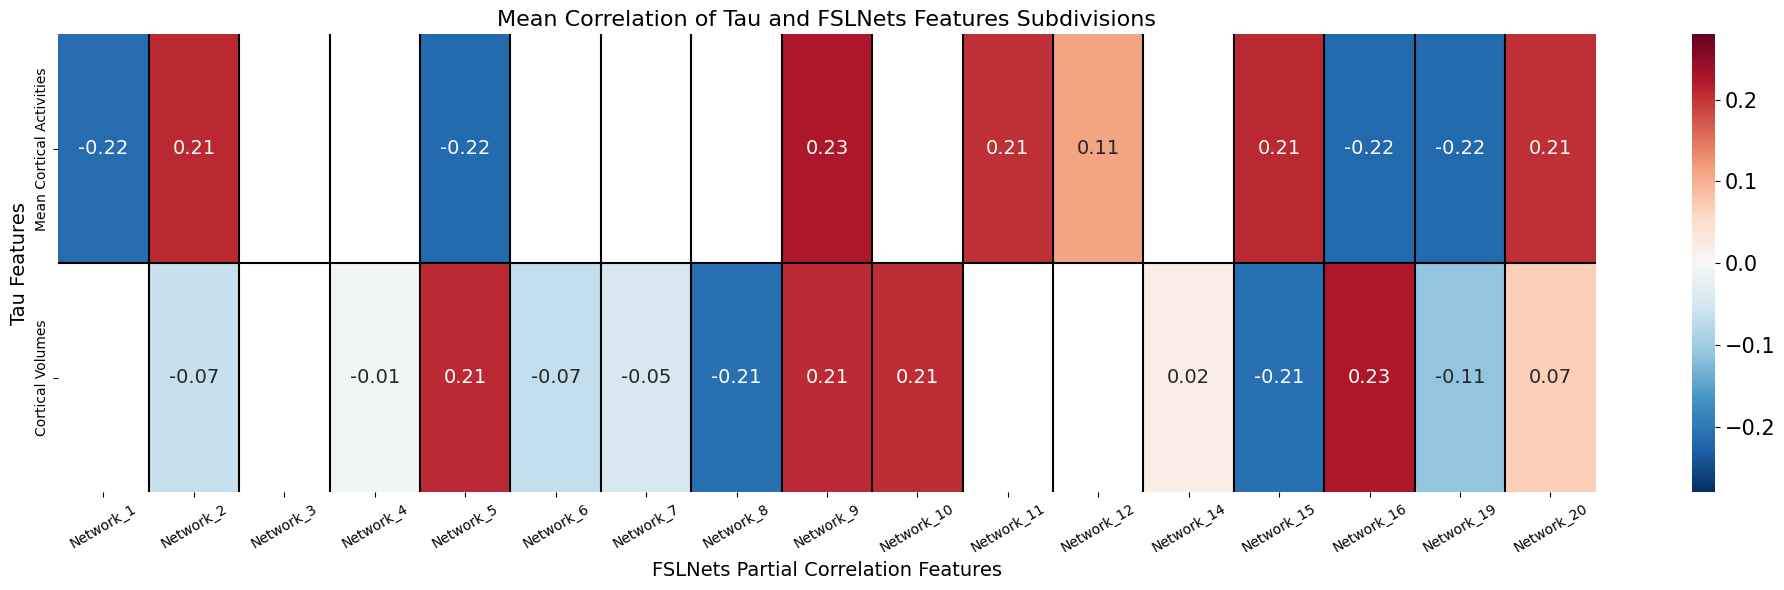

In [16]:
# AVERAGE CORRELATION OF TAU AND FSLNETS FEATURES - SUBDIVIDED

# Number of horizontal and vertical subdivisions
num_horizontal_subdivisions = 2  # For 2 rows
num_vertical_subdivisions = 17   # For 17 columns

# Calculate step sizes for horizontal and vertical subdivisions
step_h = correlation_matrix_significant.shape[0] // num_horizontal_subdivisions
step_v = correlation_matrix_significant.shape[1] // num_vertical_subdivisions

# -------------------------------
# Calculate the Mean of Each Subdivision
# -------------------------------

# Initialize a matrix to store mean values (2 rows x 17 columns)
mean_matrix = np.empty((num_horizontal_subdivisions, num_vertical_subdivisions))
mean_matrix[:] = np.nan  # Initialize with NaN

for i in range(num_horizontal_subdivisions):
    # Define the row range for the current horizontal subdivision
    start_row = i * step_h
    end_row = (i + 1) * step_h if i < num_horizontal_subdivisions - 1 else correlation_matrix_significant.shape[0]
    
    for j in range(num_vertical_subdivisions):
        # Define the column range for the current vertical subdivision
        start_col = j * step_v
        end_col = (j + 1) * step_v if j < num_vertical_subdivisions - 1 else correlation_matrix_significant.shape[1]
        
        # Extract the subset of the matrix for the current subdivision
        subset = correlation_matrix_significant[start_row:end_row, start_col:end_col]
        
        # Calculate the mean, ignoring NaN values
        mean_value = np.nanmean(subset)
        
        # Store the mean in the mean_matrix
        mean_matrix[i, j] = mean_value

# -------------------------------
# Plot the Mean Subdivisions Heatmap
# -------------------------------

x_ticks = [f'Network_{k+1}' for k in goodnodes]
y_ticks = ['Mean Cortical Activities', 'Cortical Volumes']

plt.figure(figsize=(20, 6))

# Plot the heatmap
heatmap = sns.heatmap(
    mean_matrix,
    cmap='RdBu_r',
    annot=True,
    fmt=".2f",
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    vmin=-0.28,
    vmax=0.28,
    annot_kws={"size": 14}  # Make annotation numbers larger
)

# Adjust the colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=15)  # Make colorbar numbers larger

# Rotate x-axis labels
plt.xticks(rotation=30)

# Add title and labels
plt.title('Mean Correlation of Tau and FSLNets Features Subdivisions', fontsize=16)
plt.xlabel('FSLNets Partial Correlation Features', fontsize=14)
plt.ylabel('Tau Features', fontsize=14)

# Add vertical lines to separate vertical subdivisions
for j in range(1, num_vertical_subdivisions):
    plt.axvline(j, color='black', linewidth=1.5)

# Add horizontal lines to separate horizontal subdivisions
for i in range(1, num_horizontal_subdivisions):
    plt.axhline(i, color='black', linewidth=1.5)

# Display the plot
plt.tight_layout()
plt.show()


## Data Visualization

Number of rows left: 308


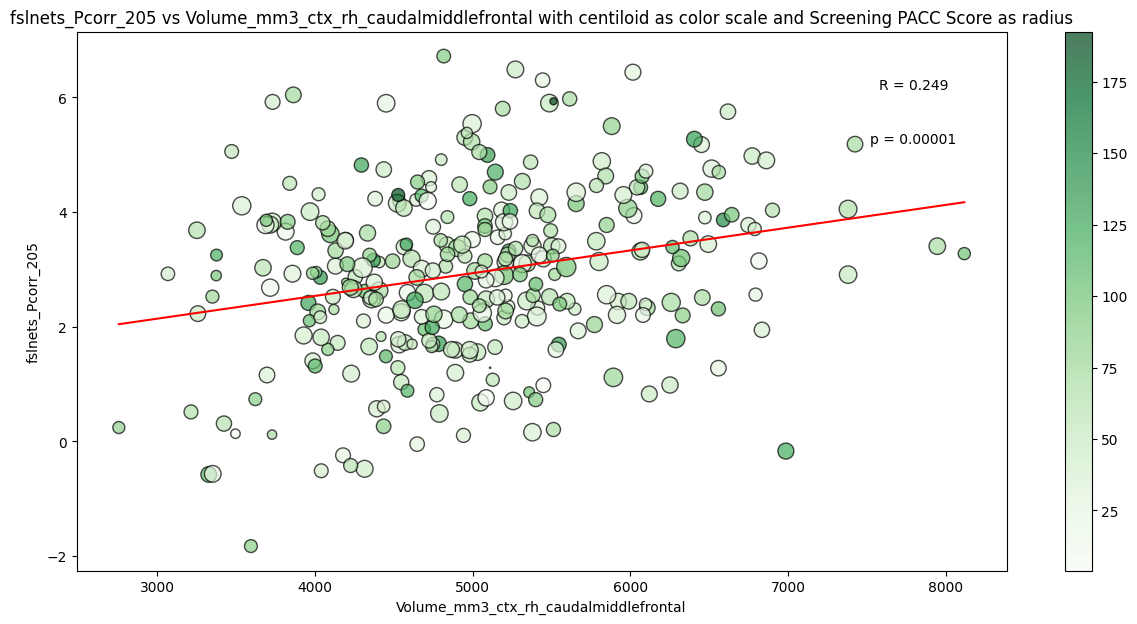

In [17]:
datagraf2 = data.copy()

feature1, feature2, feature3, feature4 = 'Volume_mm3_ctx_rh_caudalmiddlefrontal', 'fslnets_Pcorr_205', 'centiloid', 'Screening PACC Score'
# x, y, color, radius

if feature1 in columns_Tau:
    datagraf2.dropna(subset=[feature1], inplace=True)
elif feature2 in columns_Tau:
    datagraf2.dropna(subset=[feature2], inplace=True)
elif feature3 in columns_Tau:
    datagraf2.dropna(subset=[feature3], inplace=True)
elif feature4 in columns_Tau:
    datagraf2.dropna(subset=[feature4], inplace=True)

print('Number of rows left:', len(datagraf2))

rad_min, rad_max = 1, 200
scaled_radii = (datagraf2[feature4] - datagraf2[feature4].min()) / (datagraf2[feature4].max() - datagraf2[feature4].min()) * (rad_max - rad_min) + rad_min

plt.figure(figsize=(15, 7))
plt.scatter(datagraf2[feature1], datagraf2[feature2], c=datagraf2[feature3], s=scaled_radii, cmap='Greens', alpha=0.7, edgecolors='k')
plt.colorbar()
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'{feature2} vs {feature1} with {feature3} as color scale and {feature4} as radius')
x_values = np.unique(datagraf2[feature1])
y_values = np.poly1d(np.polyfit(datagraf2[feature1], datagraf2[feature2], 1))(x_values)
plt.plot(x_values, y_values, color='red')
r = np.corrcoef(datagraf2[feature1], datagraf2[feature2])[0, 1]
a, b, r, p_value,c = stats.linregress(datagraf2[feature1], datagraf2[feature2])
plt.text(0.9, 0.9, f'R = {r:.3f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.9, 0.8, f'p = {p_value:.5f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


